In [20]:
import pandas as pd
import matplotlib.pyplot as plt

plt.rc("font", family="Malgun Gothic")
plt.rcParams["axes.unicode_minus"] = False

df:pd.DataFrame = pd.read_csv("./subway_by_time.csv", encoding="utf-8")
df.head(3)


,사용월,호선명,역ID,지하철역,04:00:00~04:59:59,Unnamed: 5,05:00:00~05:59:59,Unnamed: 7,06:00:00~06:59:59,Unnamed: 9,...,Unnamed: 43,00:00:00~00:59:59,Unnamed: 45,01:00:00~01:59:59,Unnamed: 47,02:00:00~02:59:59,Unnamed: 49,03:00:00~03:59:59,Unnamed: 51,작업일시
0,NaN,NaN,NaN,NaN,승차,하차,승차,하차,승차,하차,...,하차,승차,하차,승차,하차,승차,하차,승차,하차,NaN
1,2021-12-01,1호선,1.0,서울역,769,16,"8,460","6,094","11,185","35,735",...,"8,703",61,841,0,2,0,0,0,0,2022-01-03 10:00
2,2021-12-01,1호선,10.0,동묘앞,116,0,"2,423",756,"3,270","3,915",...,"2,491",10,"1,437",1,1,0,1,0,0,2022-01-03 10:00


In [21]:
# save columns first,
cols: list[str] = df.columns.tolist()
cols2: list[str] = df.iloc[0, :].fillna(0).to_list()



In [22]:
# preprocessing

# drop first row
df.dropna(inplace=True)

# modify cols struct
for idx, val in enumerate(cols):
    if "Unnamed" in val:
        cols[idx] = cols[idx - 1]

df.columns = [cols, cols2]

# to datetime
df[("사용월", 0)] = pd.to_datetime(df[("사용월", 0)])
df[("작업일시", 0)] = pd.to_datetime(df[("작업일시", 0)])

# to number
df = df.applymap(
    lambda x: x.replace(",", "") if (isinstance(x, str) and x.find(",") != -1) else x
)
times:list[str] = list(filter(lambda x: x.find(":00:") != -1, cols))

for i in times:
    df[(i, "승차")] = pd.to_numeric(df[(i, "승차")])
    df[(i, "하차")] = pd.to_numeric(df[(i, "하차")])

df.head(5)


사용월  호선명   역ID  지하철역 04:00:00~04:59:59     05:00:00~05:59:59        \
           0    0     0     0                승차  하차                승차    하차   
1 2021-12-01  1호선   1.0   서울역               769  16              8460  6094   
2 2021-12-01  1호선  10.0   동묘앞               116   0              2423   756   
3 2021-12-01  1호선   2.0    시청                37   2              1902  4537   
4 2021-12-01  1호선   3.0    종각               105   0              2285  3792   
5 2021-12-01  1호선   4.0  종로3가               148  16              2779  2704   

  06:00:00~06:59:59         ... 23:00:00~23:59:59 00:00:00~00:59:59        \
                 승차     하차  ...                하차                승차    하차   
1             11185  35735  ...              8703                61   841   
2              3270   3915  ...              2491                10  1437   
3              2827  19095  ...              1713                28   153   
4              2955  19570  ...              1962                92   175   
5              3067  11938  ...              2313                76   609   

  01:00:00~01:59:59    02:00:00~02:59:59    03:00:00~03:59:59     \
                 승차 하차                승차 하차                승차 하차   
1                 0  2                 0  0                 0  0   
2                 1  1                 0  1                 0  0   
3                 0  1                 0  0                 0  0   
4                 0  0                 1  1                 0  0   
5                 1  0                 0  0                 0  0   

                 작업일시  
                    0  
1 2022-01-03 10:00:00  
2 2022-01-03 10:00:00  
3 2022-01-03 10:00:00  
4 2022-01-03 10:00:00  
5 2022-01-03 10:00:00  

[5 rows x 53 columns]

In [23]:
# 특정 시간대 가장 많은 사람이 타는 역을 찾아보자

time_line = "07:00:00~07:59:59"

df_time_line:pd.DataFrame = (
    df.loc[:, ["호선명", time_line]]
    .droplevel(level=0, axis=1)
    .groupby([0])
    .sum()
    .reset_index(level=0)
)
df_time_line

# get max
station_in_most:pd.DataFrame = df_time_line[df_time_line["승차"] == df_time_line["승차"].max()]
station_out_most:pd.DataFrame = df_time_line[df_time_line["하차"] == df_time_line["하차"].max()]

print(station_in_most)
print(station_out_most)


     0       승차       하차
1  2호선  2007221  1734760
     0       승차       하차
1  2호선  2007221  1734760


In [24]:
# get sum of population

stations:pd.DataFrame = df_time_line[0]
pop_sum:pd.Series = df_time_line["승차"] + df_time_line["하차"]

union:pd.DataFrame = pd.concat([stations, pop_sum], axis=1)
union.columns = ["station", "sumOf"]
union.sort_values(by="sumOf", inplace=True, ascending=False)



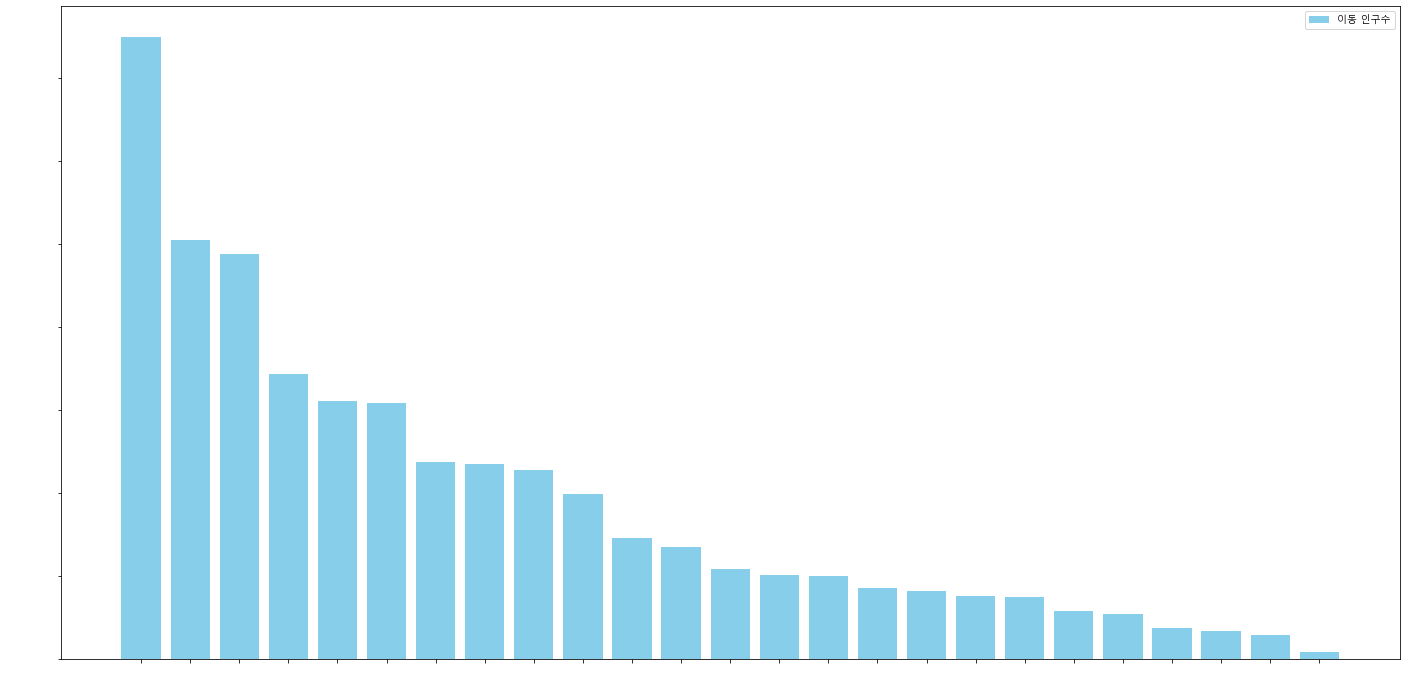

In [25]:
# draw bar chart

plt.figure(figsize=(24, 12))

plt.bar(union["station"], union["sumOf"], label="이동 인구수", color="skyblue")

plt.xticks(size=10, color="white")
plt.yticks(size=12, color="white")
plt.ticklabel_format(style="sci", axis="y", scilimits=(0, 100))

plt.legend()
plt.show()
plt.close()


In [26]:
# 시간대별로 가장 많이 타고 내리는 역을 찾고 표로 나타내기

df.head(3)

original_columns:pd.Index = df.columns

columns_first = original_columns.map(lambda x: x[0]).unique().tolist()
columns_first.remove("사용월")
columns_first.remove("역ID")
columns_first.remove("지하철역")
columns_first.remove("작업일시")

parsed: pd.DataFrame = pd.DataFrame(df[columns_first[0]])
for i in columns_first[1:]:
    series = df[i].sum(axis=1)
    parsed = pd.concat([parsed, series], axis=1)
parsed.columns = columns_first

df_by_station:pd.DataFrame = parsed.groupby(by="호선명").sum().reset_index(level=0)
df_by_station.head(3)


,호선명,04:00:00~04:59:59,05:00:00~05:59:59,06:00:00~06:59:59,07:00:00~07:59:59,08:00:00~08:59:59,09:00:00~09:59:59,10:00:00~10:59:59,11:00:00~11:59:59,12:00:00~12:59:59,...,18:00:00~18:59:59,19:00:00~19:59:59,20:00:00~20:59:59,21:00:00~21:59:59,22:00:00~22:59:59,23:00:00~23:59:59,00:00:00~00:59:59,01:00:00~01:59:59,02:00:00~02:59:59,03:00:00~03:59:59
0,1호선,3726,84805,210805,502305,1117183,744416,551072,609735,672121,...,1155033,571759,419491,433886,241248,95858,7717,8,4,0
1,2호선,12753,518263,1456021,3741981,7645512,5164649,3078483,2875916,3112844,...,8152358,4796156,3407549,3706840,2334943,983394,50672,15,7,0
2,3호선,2106,163571,624263,1554439,2659677,1858595,1269059,1209143,1274959,...,2853872,1687544,1179724,1150174,715120,266008,18952,20,3,0


In [27]:
# get max of each time line

from functools import reduce

max_time_line = []
for i in df_by_station.columns[1:]:
    target = df_by_station[df_by_station[i] == df_by_station[i].max()].loc[
        :, ["호선명", i]
    ]
    temp = pd.DataFrame(
        {"호선명": target["호선명"].tolist()[0], "총 인구수": target[i].tolist()[0]}, index=[i]
    )
    max_time_line.append(temp)
max_time_line = reduce(lambda x, y: pd.concat([x, y]), max_time_line)
max_time_line


,호선명,총 인구수
04:00:00~04:59:59,경부선,27515
05:00:00~05:59:59,2호선,518263
06:00:00~06:59:59,2호선,1456021
07:00:00~07:59:59,2호선,3741981
08:00:00~08:59:59,2호선,7645512
09:00:00~09:59:59,2호선,5164649
10:00:00~10:59:59,2호선,3078483
11:00:00~11:59:59,2호선,2875916
12:00:00~12:59:59,2호선,3112844
13:00:00~13:59:59,2호선,3400936


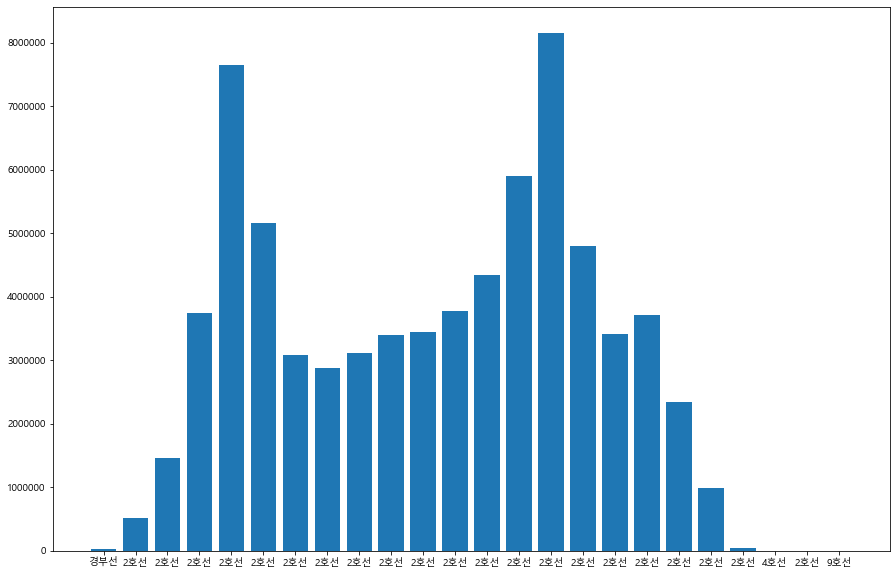

In [28]:
# draw bar chart

x_ticks = range(max_time_line.index.tolist().__len__())
x_labels = max_time_line["호선명"].tolist()

plt.figure(figsize=(15, 10))
plt.bar(x_ticks, max_time_line["총 인구수"])
plt.ticklabel_format(style="sci", axis="y", scilimits=(0, 100))
plt.xticks(x_ticks, x_labels)

plt.show()
plt.close()
